<a href="https://colab.research.google.com/github/Harsha080996/ML-assignments/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-16 22:56:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  9.25MB/s    in 7.1s    

2019-04-16 22:56:17 (9.25 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
conv_base.trainable = False

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 232ms/step - loss: 0.6170 - acc: 0.6615 - val_loss: 0.4963 - val_acc: 0.7860
Epoch 2/30
100/100 [==============================] - 20s 197ms/step - loss: 0.5193 - acc: 0.7620 - val_loss: 0.4156 - val_acc: 0.8190
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.4845 - acc: 0.7675 - val_loss: 0.3727 - val_acc: 0.8380
Epoch 4/30
100/100 [==============================] - 18s 175ms/step - loss: 0.4482 - acc: 0.8005 - val_loss: 0.3583 - val_acc: 0.8490
Epoch 5/30
100/100 [==============================] - 18s 176ms/step - loss: 0.4334 - acc: 0.7955 - val_loss: 0.3378 - val_acc: 0.8570
Epoch 6/30
100/100 [==============================] - 18s 176ms/step - loss: 0.4146 - acc: 0.8225 - val_loss: 0.3195 - val_acc: 0.8460
Epoch 7/30
100/100 [==============================] - 19s 

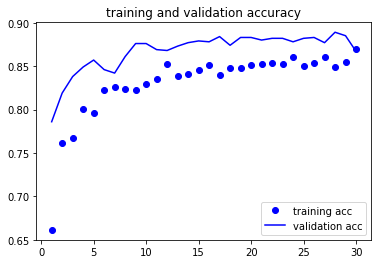

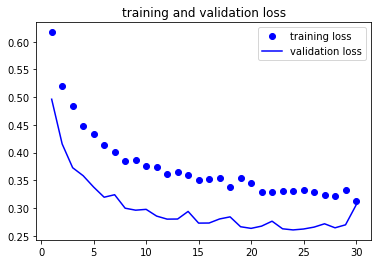

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 204ms/step - loss: 0.3453 - acc: 0.8520 - val_loss: 0.2205 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 19s 194ms/step - loss: 0.2923 - acc: 0.8745 - val_loss: 0.2360 - val_acc: 0.9010
Epoch 3/100
100/100 [==============================] - 18s 183ms/step - loss: 0.2614 - acc: 0.8895 - val_loss: 0.2140 - val_acc: 0.9090
Epoch 4/100
100/100 [==============================] - 20s 198ms/step - loss: 0.2307 - acc: 0.9005 - val_loss: 0.3046 - val_acc: 0.9000
Epoch 5/100
100/100 [==============================] - 18s 183ms/step - loss: 0.2217 - acc: 0.9120 - val_loss: 0.2215 - val_acc: 0.9150
Epoch 6/100
100/100 [==============================] - 20s 196ms/step - loss: 0.1975 - acc: 0.9185 - val_loss: 0.1739 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 18s 185ms/step - loss: 0.1829 - acc: 0.9280 - val_loss: 0.2256 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

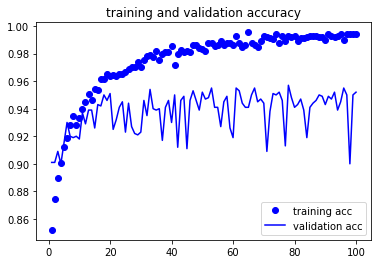

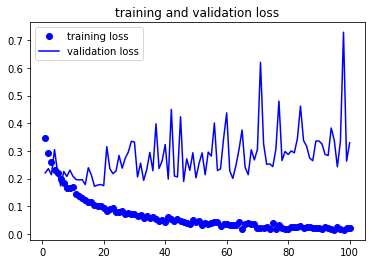

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: [0.22050369158387184, 0.2359611165523529, 0.21400620676577092, 0.30461827121675017, 0.22149195212870837, 0.17388402689248322, 0.22563636967912315, 0.2077264023013413, 0.2306423357501626, 0.2085253995656967, 0.19672835360746832, 0.19517741088289767, 0.19624389294534922, 0.1784163904003799, 0.2392421008553356, 0.2124387716781348, 0.17208372070919722, 0.17647915689623914, 0.17879165507853031, 0.1742817804403603, 0.3154527645400958, 0.23541183264926077, 0.21784388698637486, 0.22735411685105647, 0.2834811027813703, 0.23766509495209903, 0.27377856785431504, 0.2956949749338673, 0.3350232405262068, 0.33226669405121356, 0.20573252970818431, 0.2560091665940126, 0.19372395993908867, 0.23244470874546097, 0.29460983696393667, 0.22835228695359547, 0.3982063936721534, 0.2365792486182181, 0.26372993578435855, 0.3230276001058519, 0.19837718293259968, 0.44978888804791495, 0.20917259069392458, 0.20614431800335298, 0.4233469850782785, 0.18953480877273252, 0.27149444606591716, 0.2297442345